In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def generate_result(auc_b_c, auc_b_light, auc_c_light, label=""):
    result = {}
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    result['name'] = [label]
    return pandas.DataFrame(result)

In [27]:
def get_result(proba, labels, name="result"):
    result = generate_result(1 - roc_auc_score(labels > 0, proba[:, 0] / proba[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, proba[:, 0] / proba[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, proba[:, 1] / proba[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label=name)
    return result

In [3]:
class MyRFECV(object):
    
    def __init__(self, estimator, step, cv, features):
        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.features = features
        
    def _score(self, labels, probs):
        roc_b_c = 1 - roc_auc_score(labels > 0, probs[:, 0] / probs[:, 1], sample_weight=(labels != 2) * 1)
        roc_b_light = 1 - roc_auc_score(labels > 1, probs[:, 0] / probs[:, 2], sample_weight=(labels != 1) * 1)
        roc_c_light = 1 - roc_auc_score(labels > 1, probs[:, 1] / probs[:, 2], sample_weight=(labels != 0) * 1)
        return (roc_b_c + roc_b_light + roc_c_light) / 3.
        
    def _fit_step(self, data, features):
        sk = SklearnClassifier(self.estimator, features=None)
        folding = FoldingClassifier(sk, n_folds=self.cv, random_state=11, features=features)
        folding.fit_lds(data)
        importances = folding.feature_importances_
        indices = numpy.argsort(importances)[::-1]
        
        labels = data.target
        probs = folding.predict_proba(data.data)
        score = self._score(labels, probs)
        
        return features[indices], score
        
    def fit(self, data):
        features = self.features
        feature_list = []
        score_list = []
        
        while len(features) >= self.step:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
            features = features[:-self.step]
            
        if len(features) > 0:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
        return numpy.array(feature_list), numpy.array(score_list)

In [ ]:
%matplotlib inline
import root_numpy
import pandas
import numpy
import matplotlib.pyplot as plt
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
import cPickle as pickle

## Read data

In [8]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [9]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [10]:
full_data = pandas.concat([data_b, data_c, data_light])
full_data['label'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)

In [11]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

# Multiclassification

## Data preprocessing

In [12]:
train_data = full_data[sv_features].values
labels = full_data['label'].values

## Train

In [13]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time multi_folding.fit(train_data, labels)

CPU times: user 7min 44s, sys: 480 ms, total: 7min 45s
Wall time: 59 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [14]:
multi_probs = multi_folding.predict_proba(train_data)

KFold prediction using folds column


## Results

In [15]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
multiclass_result = generate_result(1 - roc_auc_score(labels > 0, multi_probs[:, 0] / multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 0] / multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 1] / multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='multiclass')

In [16]:
result = pandas.concat([multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949536,0.983856,0.973569


# Multiclassification + PCA

## Data preprocessing

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=train_data.shape[1])
pca_train_data = pca.fit_transform(train_data)

## Train

In [18]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
pca_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time pca_multi_folding.fit(pca_train_data, labels)

CPU times: user 7min 4s, sys: 908 ms, total: 7min 4s
Wall time: 53.3 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [19]:
pca_multi_probs = pca_multi_folding.predict_proba(pca_train_data)

KFold prediction using folds column


## Results

In [20]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
pca_multiclass_result = generate_result(1 - roc_auc_score(labels > 0, pca_multi_probs[:, 0] / pca_multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, pca_multi_probs[:, 0] / pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, pca_multi_probs[:, 1] / pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='pca_multiclass')

In [21]:
result = pandas.concat([multiclass_result, pca_multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949536,0.983856,0.973569
pca_multiclass,0.945119,0.985436,0.977200


# Multiclass + features generation + features selection

## Data preprocessing

In [24]:
full_data['log_SVFDChi2'] = numpy.log(full_data['SVFDChi2'].values)
full_data['log_SVSumIPChi2'] = numpy.log(full_data['SVSumIPChi2'].values)
full_data['P_Sin'] = 0.5*full_data['SVMC'].values - (full_data['SVM'].values)**2/(2.*full_data['SVMC'].values)
full_data['Psv'] = full_data['SVPT'].values * full_data['P_Sin'].values
full_data['Psv2'] = full_data['P_Sin'].values / full_data['SVPT'].values
full_data['Mt'] = full_data['SVMC'].values - full_data['P_Sin'].values
full_data['QtoN'] = 1. * full_data['SVQ'].values / full_data['SVN'].values
    
new_features = ['log_SVFDChi2', 'log_SVSumIPChi2', 'P_Sin', 'Psv', 'Psv2', 'Mt', 'QtoN']

In [25]:
features = []
for ind1 in range(0, len(sv_features)):
    f1 = sv_features[ind1]
    for ind2 in range(ind1, len(sv_features)):
        f2 = sv_features[ind2]
        
        full_data[f1+'_mult_'+f2] = full_data[f1].values * full_data[f2].values
        full_data[f1+'_div_'+f2] = full_data[f1].values / (full_data[f2].values + 0.1)
        full_data[f2+'_div_'+f1] = full_data[f2].values / (full_data[f1].values + 0.1)
        features.append(f1+'_mult_'+f2)
        features.append(f1+'_div_'+f2)
        features.append(f2+'_div_'+f1)

        full_data['2'+f1+'_plus_'+f2] = (full_data[f1].values**2) + (full_data[f2].values**2)
        full_data['2'+f1+'_min_'+f2] = (full_data[f1].values**2) - (full_data[f2].values**2)
        features.append('2'+f1+'_plus_'+f2)
        features.append('2'+f1+'_min_'+f2)
        
new_features += features

In [26]:
new_train_data = full_data[sv_features + new_features].values

In [28]:
full_data_lds = LabeledDataStorage(full_data, labels)

In [29]:
forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=2)
feature_list, score_list = \
MyRFECV(estimator=forest, step=10, cv=2, features=numpy.array(sv_features+new_features)).fit(full_data_lds)

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


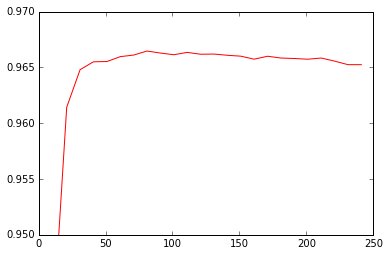

In [30]:
length = numpy.array([len(fs) for fs in feature_list])
plt.plot(length, score_list)
plt.ylim(0.95, 0.97)
plt.show()

In [31]:
sel_features = feature_list[score_list == score_list.max()][0]
len(sel_features)

81

In [32]:
sel_new_train_data = full_data[sel_features].values

## Train

In [33]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
sel_new_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time sel_new_multi_folding.fit(sel_new_train_data, labels)

CPU times: user 27min 46s, sys: 1.57 s, total: 27min 47s
Wall time: 3min 30s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [34]:
sel_new_multi_probs = sel_new_multi_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


## Results

In [35]:
sel_new_multi_results = get_result(sel_new_multi_probs, labels, "sel_new_multiclass")

In [37]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result,  
                        sel_new_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949536,0.983856,0.973569
pca_multiclass,0.945119,0.985436,0.977200
sel_new_multiclass,0.950772,0.988023,0.980581


# Grid search XGBoost

In [192]:
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from rep.metaml import GridOptimalSearchCV, FoldingScorer, RandomParameterOptimizer

class MyMeanRocAucScorer(object):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, estimator, X, y):
        cl = clone(estimator)
        cl.fit(X, y)
        metric = get_result(cl.predict_proba(self.X_test), self.y_test, '').values[0, 0:3].mean()
        return metric

## Search

In [ ]:
from sklearn.grid_search import GridSearchCV
from rep.utils import train_test_split

train_train_data, test_data, train_labels, test_labels = train_test_split(train_data, labels, test_size=0.3)

grid_param = {}
grid_param['eta'] = [0.1, 0.05, 0.01]
grid_param['max_depth'] = [6, 8, 12, 100]
grid_param['colsample'] = [0.3, 0.5, 0.7, 1.0]
grid_param['subsample'] = [0.3, 0.5, 0.7, 1.0]

xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.5, max_depth=8)

grid_xgb = GridSearchCV(estimator=xgb_base, param_grid=grid_param, cv=2, 
                    scoring=MyMeanRocAucScorer(test_data, test_labels), n_jobs=8)
grid_xgb.fit(train_train_data, train_labels)

In [208]:
grid_xgb.best_params_

{'colsample': 1.0, 'eta': 0.01, 'max_depth': 8, 'subsample': 0.5}

## Train

In [ ]:
xgb_best = grid_xgb.best_estimator_.set_params(features=None)
best_xgb_multi_folding = FoldingClassifier(xgb_best, n_folds=2, random_state=11)
%time best_xgb_multi_folding.fit(train_data, labels)

In [ ]:
# Save classifier
clf_pickle = open('best_xgb_multi_folding.pkl', 'wb')
#pickle.dump(best_xgb_multi_folding, clf_pickle)
clf_pickle.close()

In [ ]:
# Read classifier
clf_pickle2 = open('best_xgb_multi_folding.pkl', 'rb')
#best_xgb_multi_folding = pickle.load(clf_pickle2)
clf_pickle2.close()

In [ ]:
best_xgb_multi_proba = best_xgb_multi_folding.predict_proba(train_data)

## Results

In [ ]:
best_xgb_multi_results = get_result(best_xgb_multi_proba, labels, "best_xgb_multiclass")

In [200]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result,  
                        sel_new_multi_results,
                        best_xgb_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949536,0.983856,0.973569
pca_multiclass,0.945119,0.985436,0.977200
sel_new_multiclass,0.950772,0.988023,0.980581
best_xgb_multiclass,0.949341,0.984908,0.975656


# Grid search XGBoost + features generation + features selection

## Search

In [ ]:
from sklearn.grid_search import GridSearchCV
from rep.utils import train_test_split

sel_new_train_train_data, sel_new_test_data, sel_new_train_labels, sel_new_test_labels = \
train_test_split(sel_new_train_data, labels, test_size=0.3)

grid_param = {}
grid_param['eta'] = [0.1, 0.05, 0.01]
grid_param['max_depth'] = [6, 8, 12, 100]
grid_param['colsample'] = [0.3, 0.5, 0.7, 1.0]
grid_param['subsample'] = [0.3, 0.5, 0.7, 1.0]

xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.5, max_depth=8)

sel_new_grid_xgb = GridSearchCV(estimator=xgb_base, param_grid=grid_param, cv=2, 
                    scoring=MyMeanRocAucScorer(sel_new_test_data, sel_new_test_labels), n_jobs=8)
sel_new_grid_xgb.fit(sel_new_train_train_data, sel_new_train_labels)

In [241]:
sel_new_grid_xgb.best_params_

{'colsample': 0.7, 'eta': 0.01, 'max_depth': 6, 'subsample': 0.5}

## Train

In [ ]:
sel_new_xgb_best = sel_new_grid_xgb.best_estimator_.set_params(features=None)
sel_new_best_xgb_multi_folding = FoldingClassifier(sel_new_xgb_best, n_folds=2, random_state=11)
%time sel_new_best_xgb_multi_folding.fit(sel_new_train_data, labels)

In [ ]:
# Save classifier
clf_pickle = open('sel_new_best_xgb_multi_folding.pkl', 'wb')
#pickle.dump(sel_new_best_xgb_multi_folding, clf_pickle)
clf_pickle.close()

In [ ]:
# Read classifier
clf_pickle2 = open('sel_new_best_xgb_multi_folding.pkl', 'rb')
#sel_new_best_xgb_multi_folding = pickle.load(clf_pickle2)
clf_pickle2.close()

In [ ]:
sel_new_best_xgb_multi_proba = sel_new_best_xgb_multi_folding.predict_proba(sel_new_train_data)

## Results

In [ ]:
sel_new_best_xgb_multi_results = get_result(sel_new_best_xgb_multi_proba, labels, "sel_new_best_xgb_multiclass")

In [242]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result,  
                        sel_new_multi_results,
                        best_xgb_multi_results,
                        sel_new_best_xgb_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949536,0.983856,0.973569
pca_multiclass,0.945119,0.985436,0.977200
sel_new_multiclass,0.950772,0.988023,0.980581
best_xgb_multiclass,0.949341,0.984908,0.975656
sel_new_best_xgb_multiclass,0.951279,0.987887,0.980127
